In [1]:
import tensorflow as tf
import sklearn
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow import keras
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
tf.random.set_seed(42)
img_directory = r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\cwt\cwt_no_comon_scale_matrix"
df = pd.read_csv(r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\cwt\cwt_no_comon_scale_case_matrix_temp_info.csv",
                header=0, index_col=0)

lb = LabelEncoder()
df["case"] = lb.fit_transform(df["case"])

sc = StandardScaler()
df["temperature"] = sc.fit_transform(df["temperature"].values.reshape(-1, 1))

df_train, df_val = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)

In [9]:
import tensorflow as tf
from scipy.sparse import load_npz
from PIL import Image
import numpy as np
import math
import os

class CustomDataGenerator(tf.keras.utils.Sequence):

    ''' Custom DataGenerator to load img 
    
    Arguments:
        data_frame = pandas data frame in filenames and labels format
        batch_size = divide data in batches
        shuffle = shuffle data before loading
        img_shape = image shape in (h, w, d) format
        augmentation = data augmentation to make model rebust to overfitting
    
    Output:
        Img: numpy array of image
        label : output label for image
    '''
    
    def __init__(self, data_frame, batch_size=10, augmentation=True, num_classes=None, folder=""):
        self.data_frame = data_frame
        self.train_len = len(data_frame)
        self.batch_size = batch_size

        self.num_classes = num_classes
        self.folder = folder
        print(f"Found {self.data_frame.shape[0]} images belonging to {self.num_classes} classes")

    def __len__(self):
        ''' return total number of batches '''
        #self.data_frame = shuffle(self.data_frame)
        return math.ceil(self.train_len/self.batch_size)

    def on_epoch_end(self):
        ''' shuffle data after every epoch '''
        # fix on epoch end it's not working, adding shuffle in len for alternative
        pass
    
    def __data_augmentation(self, img):
        ''' function for apply some data augmentation '''
        img = img
        return img
        
    def __get_image(self, file_id):
        """ open image with file_id path and apply data augmentation """
        """
        img = Image.open(os.path.join(self.folder, file_id))
        img = img.resize(self.img_shape, Image.Resampling.LANCZOS)
        img = img.convert("RGB")
        img = tf.keras.preprocessing.image.img_to_array(img) /255
        img = tf.convert_to_tensor(img)
        """
        img = load_npz(os.path.join(self.folder, file_id))
        img = img / img.max()
        img = img.toarray()
        return img

    def __get_label(self, label_id):
        """ uncomment the below line to convert label into categorical format """
        label_id = tf.keras.utils.to_categorical(label_id, self.num_classes)
        label_id = tf.convert_to_tensor(label_id)
        return label_id

    def __get_temp(self, temp):
        return temp
    
    def __getitem__(self, idx):
        batch_x = self.data_frame["filename"][idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.data_frame["case"][idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_temp = self.data_frame["temperature"][idx * self.batch_size:(idx + 1) * self.batch_size]
        # read your data here using the batch lists, batch_x and batch_y
        x = [self.__get_image(file_id) for file_id in batch_x] 
        y = [self.__get_label(label_id) for label_id in batch_y]
        temp = np.array([self.__get_temp(temp) for temp in batch_temp]).T
        data = tf.stack(x)
        label =  tf.stack(y)
        return [data, temp], label

train_generator = CustomDataGenerator(df_train, batch_size=16, augmentation=False, num_classes=13, folder=img_directory)
val_generator = CustomDataGenerator(df_val, batch_size=16, augmentation=False, num_classes=13, folder=img_directory)

Found 190847 images belonging to 13 classes
Found 47712 images belonging to 13 classes


In [10]:
img_input = layers.Input(shape=(199, 1665, 1))
temp_input = layers.Input(shape=(1,))

#Train model
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(img_input)
conv2 = layers.Conv2D(32, (3, 3), activation='relu')(conv1)
bn1 = layers.BatchNormalization()(conv2)
mp1 = layers.MaxPooling2D((2, 2))(bn1)
conv3 = layers.Conv2D(64, (3, 3), activation='relu')(mp1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu')(conv3)
bn2 = layers.BatchNormalization()(conv4)
mp2 = layers.MaxPooling2D((2, 2))(bn2)
conv5 = layers.Conv2D(128, (3, 3), activation='relu')(mp2)
gap = layers.GlobalAveragePooling2D()(conv5)

dense_gap = layers.Dense(128, activation='relu')(gap)
dense_temp = layers.Dense(1, activation="relu")(temp_input)

merged = layers.Concatenate(axis=1)([dense_gap, dense_temp])

dense_1 = layers.Dense(128, activation='relu')(merged)
drop_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(64, activation='relu')(drop_1)
drop_2 = layers.Dropout(0.2)(dense_2)
output = layers.Dense(13, activation='softmax')(drop_2)

model = models.Model(inputs=[img_input, temp_input], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 199, 1665,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 197, 1663, 3  320         ['input_5[0][0]']                
                                2)                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 195, 1661, 3  9248        ['conv2d_6[0][0]']               
                                2)                                                          

In [11]:
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
)
# Compile the model.
model.compile(
    optimizer=optimizer,
    loss=["categorical_crossentropy"],
    metrics=['accuracy']
)

In [12]:
num_epochs = 200

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# Fit the model.

history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=2,
)
print("end")

Epoch 1/200
11928/11928 - 6311s - loss: 1.0553 - accuracy: 0.6055 - val_loss: 0.6859 - val_accuracy: 0.7277 - lr: 1.0000e-04 - 6311s/epoch - 529ms/step
Epoch 2/200
11928/11928 - 6352s - loss: 0.5977 - accuracy: 0.7708 - val_loss: 0.5968 - val_accuracy: 0.7680 - lr: 1.0000e-04 - 6352s/epoch - 533ms/step
Epoch 3/200
11928/11928 - 6352s - loss: 0.4693 - accuracy: 0.8233 - val_loss: 1.0072 - val_accuracy: 0.6885 - lr: 1.0000e-04 - 6352s/epoch - 533ms/step
Epoch 4/200
11928/11928 - 6358s - loss: 0.3918 - accuracy: 0.8544 - val_loss: 1.2094 - val_accuracy: 0.6093 - lr: 1.0000e-04 - 6358s/epoch - 533ms/step
Epoch 5/200
11928/11928 - 6355s - loss: 0.3435 - accuracy: 0.8749 - val_loss: 0.4094 - val_accuracy: 0.8457 - lr: 1.0000e-04 - 6355s/epoch - 533ms/step
Epoch 6/200
11928/11928 - 6353s - loss: 0.3100 - accuracy: 0.8874 - val_loss: 0.4007 - val_accuracy: 0.8548 - lr: 1.0000e-04 - 6353s/epoch - 533ms/step
Epoch 7/200
11928/11928 - 6361s - loss: 0.2808 - accuracy: 0.8982 - val_loss: 0.8445 - v

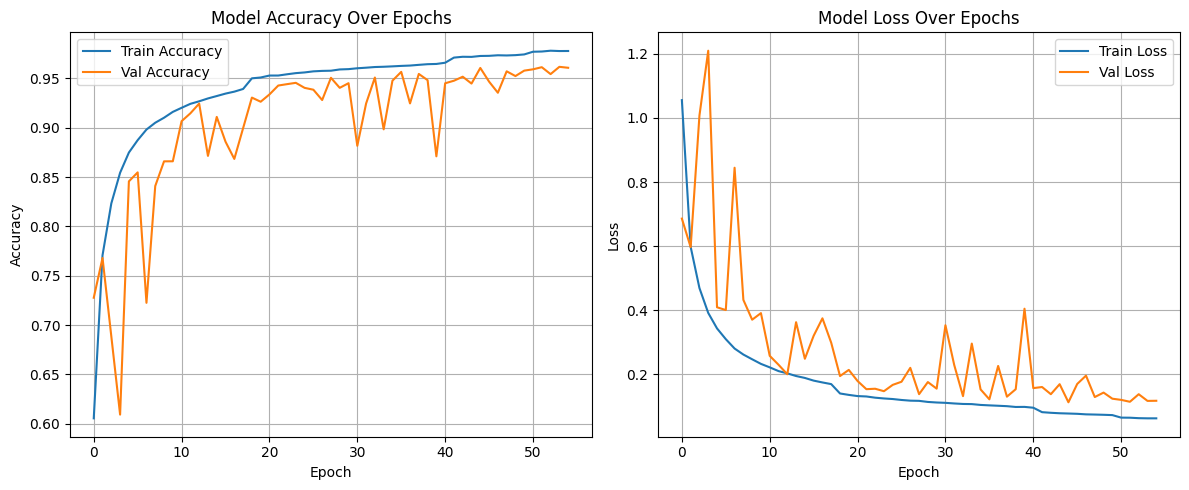

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
model.save(r'C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\models\cwt_all_std_force_quality\Conv2D_matrix.h5', save_format="h5")

2982/2982 [==============================] - 951s 319ms/step


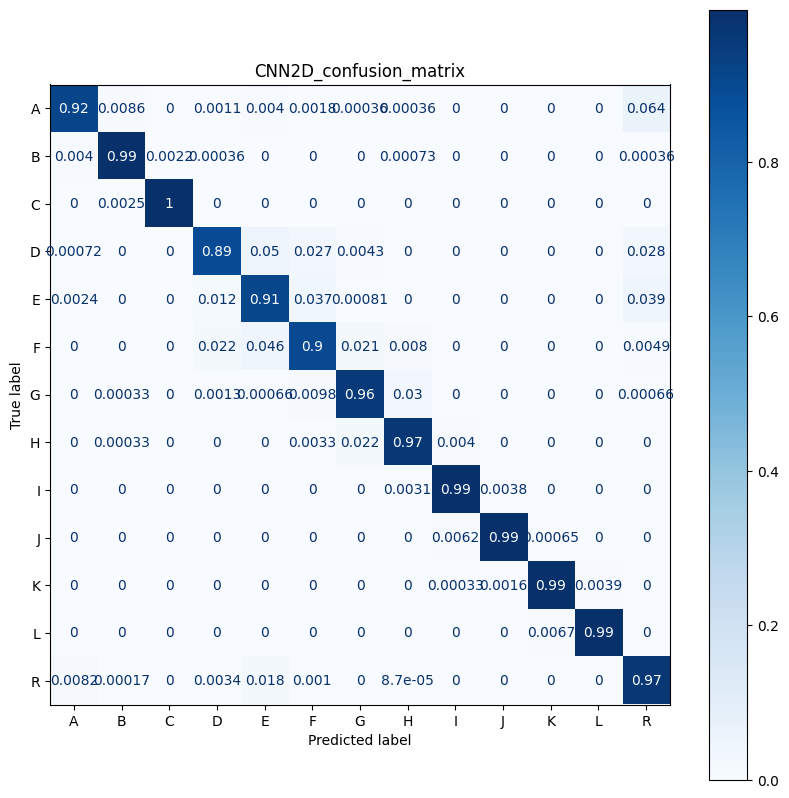

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred, axis = 1)
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay.from_predictions(
    df_val["case"],
    y_pred,
    display_labels=lb.inverse_transform(range(0, 13)),
    cmap=plt.cm.Blues,
    normalize="true",
    ax=ax
)
disp.ax_.set_title("CNN2D_confusion_matrix")

plt.show()

In [15]:
_, accuracy = model.evaluate(val_generator)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

2982/2982 [==============================] - 956s 320ms/step - loss: 0.1131 - accuracy: 0.9606
Test accuracy: 96.06%
